In [1]:
# Put these at the top of every notebook to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# General imports
from fastai.imports import *
# Data augmentation (transformations)
from fastai.transforms import * 
# Convolutional learner class
from fastai.conv_learner import *
# Model architecture
from fastai.model import *
# Dataset handling class
from fastai.dataset import *
# SGD with restarts
from fastai.sgdr import *
# Plotting
from fastai.plots import *

# Check GPU hardware is available
print(f'Cuda available: {torch.cuda.is_available()}')
print(f'Cudnn enabled:  {torch.backends.cudnn.enabled}')

PATH = "/home/paperspace/data/dogscats/"

# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

sz = 224
arch = resnet34

Cuda available: True
Cudnn enabled:  True


In [2]:
tfms = tfms_from_model(f_model=arch, sz=sz) # this is has no transformation
data = ImageClassifierData.from_paths(path=PATH, tfms=tfms)
# learn = ConvLearner.pretrained(f=arch, data=data, precompute=True)

log_preds = np.load('log_preds.npy', allow_pickle=False)

In [ ]:
def most_by_mask(mask, mult):
    """called by most_by_correct
    returns an array of image IDs given a boolean matrix"""
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    """returns an array of image IDs"""
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)


def load_img_id(ds, idx):
    """called by plot_val_with_title
    load a pic & return it as a np.array"""
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plots(ims, figsize=(12,6), rows=1, titles=None):
    """called by plot_val_with_title
    create a subplot of pics"""
    f = plt.figure(figsize=figsize) # figsize: Width, Height in inches
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1) # add_subplot(nrows, ncols, index)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def plot_val_with_title(idxs, title):
    """take a list of image indicies and plot them on a row"""
    imgs = [load_img_id(data.val_ds,x) for x in idxs]# a list of images
    title_probs = [probs[x] for x in idxs]# a list probabilities
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')


### Objective

Dissect and recreate these:

```python
def most_by_mask(mask, mult):
    """called by most_by_correct
    returns an array of image IDs given a boolean matrix"""
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    """returns an array of image IDs"""
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

```

From [stackoverflow](https://stackoverflow.com/q/6910641/9762732), to get the top K indicies from an array, use `np.argsort()`, then get the top K with slicing.

In `most_by_correct`, there is a `mult` variable. Recall that `log_preds` are full of negative values. A `mult` of negative 1 will flip the negative values positive. This will make the smallest values become the largest, and help us get the most correct _and_ most incorrect rows.

`y` is the category you want to select.

In [9]:
# Play with np.argsort()
z = np.arange(9)
np.random.shuffle(z)

In [10]:
z

array([2, 6, 5, 0, 8, 1, 4, 7, 3])

In [22]:
# returns INDICIES!!
np.argsort(z)

array([3, 5, 0])

---

### Assignment

Given these variables:
- `log_preds` : a (2000, 2) array of log probabilities for cats & dogs
- `data.val_y` : an (2000,) array of 1s and 0s

1. Find the row indicies that are _most_ correct.
1. Find the row indicies that are _most_ incorrect
1. Plot 8 of the _most_ incorrect images

Recall that `log_preds` is returned by `learn.predict()`. This is the result we have to work with.

---

In [34]:
preds = log_preds.argmax(axis=1)
preds

array([0, 0, 0, ..., 1, 1, 1])

In [44]:
# Find the correct predictions
def grade(predictons, answers, is_correct=True, indicies=True):
    return np.where((predictons==answers)==is_correct)[0] if indicies else (predictons==answers)==is_correct

In [36]:
# get the probs
probs = np.exp(log_preds)
probs

array([[ 0.99993,  0.00007],
       [ 0.99601,  0.00399],
       [ 0.99904,  0.00096],
       ..., 
       [ 0.00081,  0.99919],
       [ 0.00052,  0.99948],
       [ 0.00072,  0.99928]], dtype=float32)

Pick 1 column to work with: probs closer to 1 means dogs, closer to 0 means cats. This corresponds well with their labels: 1 for dog, 0 for cat.

In [37]:
# probs for dogs
probs = probs[:,1]
probs

array([ 0.00007,  0.00399,  0.00096, ...,  0.99919,  0.99948,  0.99928], dtype=float32)

In [55]:
# probs for correct dogs (1985)
probs[grade(preds, data.val_y, indicies=False)]

array([ 0.00007,  0.00399,  0.00096, ...,  0.99919,  0.99948,  0.99928], dtype=float32)

In [58]:
# find the indicies of 5 highest probs
best5 = np.argsort(probs[grade(preds, data.val_y, indicies=False)])[:5]
best5

array([809, 731, 776, 888, 633])

In [59]:
def get_path(indicies, data_obj):
    return [data_obj.val_ds.path+data_obj.val_ds.fnames[i] for i in indicies]

In [60]:
get_path(best5, data)

['/home/paperspace/data/dogscats/valid/cats/cat.10221.jpg',
 '/home/paperspace/data/dogscats/valid/cats/cat.3710.jpg',
 '/home/paperspace/data/dogscats/valid/cats/cat.2071.jpg',
 '/home/paperspace/data/dogscats/valid/cats/cat.9923.jpg',
 '/home/paperspace/data/dogscats/valid/cats/cat.10580.jpg']

In [64]:
def plotn(paths, cols_per_row):
    plt.figure(figsize=(12,6))
    for i in range(len(paths)):
        plt.subplot(len(paths)//cols_per_row, cols_per_row, i+1)
        plt.imshow(plt.imread(paths[i]))

ValueError: num must be 1 <= num <= 4, not 5

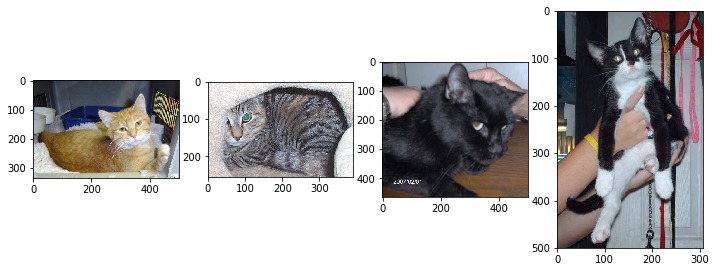

In [65]:
plotn(get_path(best5, data), 4)

In [50]:
# WITHIN correct answers, use argsort to find 5 highest values
np.argsort(probs==grade(preds, data.val_y, indicies=False))[:5]

array([   0, 1340, 1339, 1338, 1337])

In [51]:
# WITHIN correct answers, use argsort to find 5 lowest values
np.argsort(probs*-1==grade(preds, data.val_y, indicies=False))[:5]

array([   0, 1341, 1340, 1339, 1338])